In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from robustness.tools.label_maps import CLASS_DICT
import os
import sys

sys.path.append('../src')
import pandas as pd
import numpy as np

In [2]:
sns.set()
sns.set(style='ticks', font='sans-serif', font_scale=1.5)
plt.style.use('ggplot')

In [3]:
resnet_name = 'ResNet-50'
deit_name = 'ViT-S (Blacking Pixels)'
miss_deit_name = 'ViT-S'
inception_name = 'InceptionV3'
robust_name = 'Robust ResNet-50'

resnet_small_name = 'ResNet-18'
deit_tiny_name = 'ViT-T'

MODEL_NAMES = [
    'deit_small_resnet_aug', 
    'resnet50', 
    'deit_small_resnet_aug_missingness',
    'resnet18',
    'deit_tiny_resnet_aug_missingness',
    'inceptionv3',
    'robust_resnet50',
    'deit',
]
mapping_name_ = {
    'resnet50': resnet_name,
    'resnet18': resnet_small_name,
    'resnet50_deitaug': resnet_name,
    'deit_small_patch16_224': deit_name,
    'deit_small_resnet_aug': deit_name,
    'deit_small_patch16_224_missingness': miss_deit_name,
    'deit_small_resnet_aug_missingness': miss_deit_name,
    'deit_tiny_resnet_aug_missingness': deit_tiny_name,
    'inceptionv3': inception_name,
    'robust_resnet50': robust_name,
    'deit': miss_deit_name,
}

COLORS = {resnet_name: 'red', deit_name: 'green', miss_deit_name: 'blue', resnet_small_name: 'red', deit_tiny_name: 'blue', inception_name: 'red', robust_name: 'red'}
METHODS = [
    ('random', 'Random Order', '-'),
    ('Saliency', 'Most Salient First', ':'),
    ('Saliency_reverse', 'Least Salient First', '--'),
]
ROOT = "/mnt/nfs/home/saachij/src/CausalDomainTransfer/patch_ablation/missingness_results"

In [4]:
# ENTROPY CALCULATIONS
def get_entropy(count_vec):
    tot = sum(count_vec)
    preds = count_vec/tot
    entropy = -sum(preds * np.log(preds))
    return entropy

def get_entropies_and_counts(out_dict, total_patches, skip_factor):
    preds = out_dict['mask_preds']
    label_map = CLASS_DICT['ImageNet']
    all_counts, all_entropies = {}, {}
    for method in preds.keys():
        entropies, counts = [], []
        for i in range(len(np.arange(0, total_patches, skip_factor))):
            labels_in_cls = {}
            predicted_labels = preds[method][i].numpy()
            for l in predicted_labels:
                if l not in labels_in_cls:
                    label_name = label_map[l].split(",")[0]
                    labels_in_cls[l] = [label_name, 1]
                else:
                    labels_in_cls[l][1] += 1
            out = sorted([(count, name) for name, count in labels_in_cls.values()])[::-1]
            counts.append(out)
            entropies.append(get_entropy(np.array([r[0] for r in out])))
        all_counts[method] = counts
        all_entropies[method] = entropies
    return all_entropies, all_counts

def get_envelope(out_dict):
    accs, soft_accs = out_dict['mask_accs'], out_dict['mask_soft_labels']
    df = pd.DataFrame()
    all_accuracies = {}
    for m in accs.keys():
        acc_mat = accs[m]
        mean_acc = torch.mean(acc_mat.float(), -1)
        all_accuracies[m] = mean_acc.numpy()
    all_soft_accuracies = {}
    for m in accs.keys():
        soft_mat = soft_accs[m]
        mean_score = torch.mean(soft_mat.float(), -1)
        all_soft_accuracies[m] = mean_score.numpy()
    return all_accuracies, all_soft_accuracies

In [5]:
def unwrap_envelopes(root_dirs):
    all_out_dicts = {}
    for model_name in root_dirs.keys():
        root_dir = root_dirs[model_name]
        label_map = CLASS_DICT['CIFAR']
        import pickle as pkl
        with open(os.path.join(root_dir, 'envelope.pkl'), 'rb') as f:
            out = pkl.load(f)
            all_out_dicts[model_name] = out
    return all_out_dicts

def unwrap_all_out_dicts(all_out_dicts, total_patches, skip_factor):
    model_counts, model_entropies, model_accuracies, model_soft_accuracies = {}, {}, {}, {}
    for model_name, out_dict in all_out_dicts.items():
        model_entropies[model_name], model_counts[model_name] = get_entropies_and_counts(out_dict, total_patches, skip_factor)
        model_accuracies[model_name], model_soft_accuracies[model_name] = get_envelope(out_dict)
    return model_counts, model_entropies, model_accuracies, model_soft_accuracies
        
def unwrap_wordnet_scores(all_out_dicts):
    wordnet_scores, wordnet_scores_inc = {}, {}
    for model_name, out_dict in all_out_dicts.items():
        wordnet_scores[model_name], wordnet_scores_inc[model_name] = get_wordnet_scores(out_dict)   
    return wordnet_scores, wordnet_scores_inc

In [6]:
# plot entropy
def patch_plots(ax, result_dict, x_label, y_label, title, method_subset=None):
#     fig, ax = plt.subplots(1, 3,figsize=(18, 5))
    for i, (method, method_name, method_style) in enumerate(METHODS):
        if method_subset is not None and method not in method_subset:
            continue
        for model in MODEL_NAMES:
            if model not in result_dict:
                continue
            sns.lineplot(x=patch_axis,
                         y=result_dict[model][method], 
                         ax=ax,
                         color=COLORS[mapping_name_[model]],
                         linestyle=method_style,
                         linewidth=2)
        if title is not None:
            ax.set_title(title, fontsize=15)
        ax.set_ylabel(y_label, fontsize=15)
        ax.set_xlabel(x_label, fontsize=15)
        ax.legend([],[], frameon=False)
#         if i !=2:
#             ax.legend([],[], frameon=False)
#         else:
#             ax[i].legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
#     fig.savefig(filename, bbox_inches='tight')
#     plt.show()


In [8]:
patch_size = 16
skip_factor = 2

num_patches = 224//patch_size
total_patches = num_patches*num_patches + 1
patch_axis = np.arange(0, total_patches , skip_factor)


In [9]:
root_dirs = {}
folder_name = "cifar_patch_16_0_0"
for u in ['deit', 'resnet50']: 
    root_dirs[u] = os.path.join(ROOT, folder_name, u)


In [10]:
all_out_dicts = unwrap_envelopes(root_dirs)
model_counts, model_entropies, model_accuracies, model_soft_accuracies = unwrap_all_out_dicts(all_out_dicts, total_patches, skip_factor)

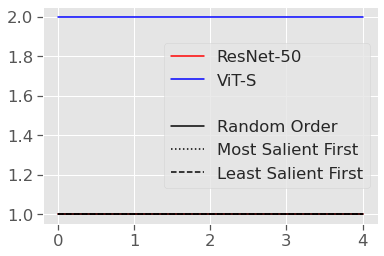

In [11]:
def get_handles(method_subset=None):
    fig, ax = plt.subplots(1, 1)
    dummy_x = np.arange(5)
    dummy_y = np.ones(5)
    for i, model_name in enumerate(['resnet50', 'deit']):
        pretty_name = mapping_name_[model_name]
        sns.lineplot(x=dummy_x, y=dummy_y+i, color=COLORS[pretty_name], linestyle='-', label=pretty_name, ax=ax)
    ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
    
    if method_subset is not None:
        m_to_consider = [u for u in METHODS if u[0] in method_subset]
    else:
        m_to_consider = METHODS
    if len(m_to_consider) > 1:
        for m, method, style in METHODS:
            sns.lineplot(x=dummy_x, y=dummy_y, color='black', linestyle=style, label=method, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    plt.show()
    return handles, labels
handles, labels = get_handles()


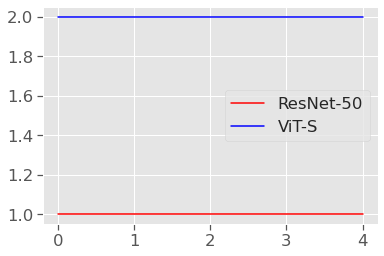

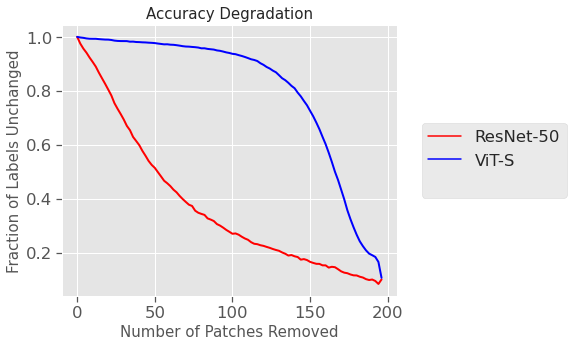

In [12]:
plot_handle, plot_label = get_handles(['random'])

fig, ax = plt.subplots(1, 1,figsize=(6, 5))
patch_plots(ax, model_accuracies, 
            "Number of Patches Removed", 
            "Fraction of Labels Unchanged",
            "Accuracy Degradation",  method_subset=['random'])
# ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.savefig(f"appendix_plots/cifar_appendix.pdf", bbox_inches='tight')
plt.show()

## Other models

In [26]:
patch_size = 16
skip_factor = 2

num_patches = 224//patch_size
total_patches = num_patches*num_patches + 1
patch_axis = np.arange(0, total_patches , skip_factor)


In [42]:
root_dirs = {}
folder = "patch_16_0_0_0"
root_dirs["deit_small_resnet_aug_missingness"] = os.path.join(ROOT, folder, "deit_small_resnet_aug_missingness")
title = "robust.pdf"
root_dirs["robust_resnet50"] = os.path.join(ROOT, folder, "robust_resnet50")


In [43]:
all_out_dicts = unwrap_envelopes(root_dirs)
model_counts, model_entropies, model_accuracies, model_soft_accuracies = unwrap_all_out_dicts(all_out_dicts, total_patches, skip_factor)
wordnet_scores, wordnet_scores_inc = unwrap_wordnet_scores(all_out_dicts)

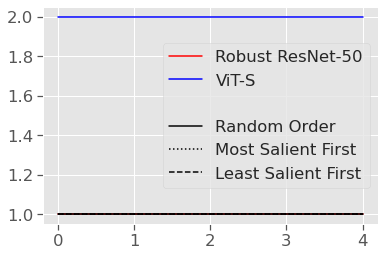

In [44]:
def get_handles(method_subset=None):
    fig, ax = plt.subplots(1, 1)
    dummy_x = np.arange(5)
    dummy_y = np.ones(5)
    for i, model_name in enumerate(['robust_resnet50', 'deit_small_resnet_aug_missingness']):
        pretty_name = mapping_name_[model_name]
        sns.lineplot(x=dummy_x, y=dummy_y+i, color=COLORS[pretty_name], linestyle='-', label=pretty_name, ax=ax)
    ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
    
    if method_subset is not None:
        m_to_consider = [u for u in METHODS if u[0] in method_subset]
    else:
        m_to_consider = METHODS
    if len(m_to_consider) > 1:
        for m, method, style in METHODS:
            sns.lineplot(x=dummy_x, y=dummy_y, color='black', linestyle=style, label=method, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    plt.show()
    return handles, labels
handles, labels = get_handles()


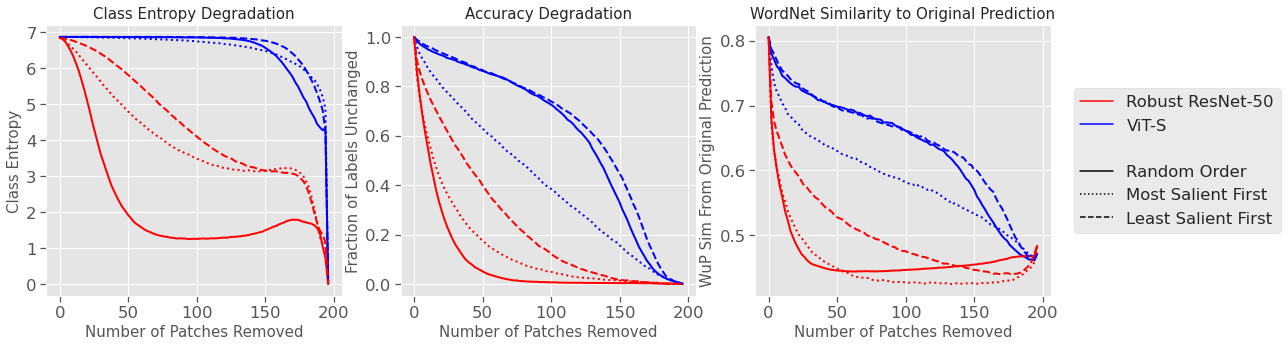

In [45]:
fig, ax = plt.subplots(1, 3,figsize=(18, 5))
patch_plots(ax[0], model_entropies, 
            "Number of Patches Removed",
            "Class Entropy", 
            "Class Entropy Degradation")
patch_plots(ax[1], model_accuracies, 
            "Number of Patches Removed", 
            "Fraction of Labels Unchanged",
            "Accuracy Degradation")
patch_plots(ax[2], wordnet_scores_inc,
            'Number of Patches Removed', 
            'WuP Sim From Original Prediction',
            'WordNet Similarity to Original Prediction')
# ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax[-1].legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.savefig(f"appendix_plots/color_patches/{title}", bbox_inches='tight')
plt.show()

## Other Arch Sizes

In [25]:
patch_size = 16
skip_factor = 2

num_patches = 224//patch_size
total_patches = num_patches*num_patches + 1
patch_axis = np.arange(0, total_patches , skip_factor)


In [45]:
root_dirs = {}
folder = "patch_16_0_0_0"
root_dirs["deit_tiny_resnet_aug_missingness"] = os.path.join(ROOT, folder, "deit_tiny_resnet_aug")
title = "small_models.pdf"
root_dirs["resnet18"] = os.path.join(ROOT, folder, "resnet18")


In [46]:
all_out_dicts = unwrap_envelopes(root_dirs)
model_counts, model_entropies, model_accuracies, model_soft_accuracies = unwrap_all_out_dicts(all_out_dicts, total_patches, skip_factor)
wordnet_scores, wordnet_scores_inc = unwrap_wordnet_scores(all_out_dicts)

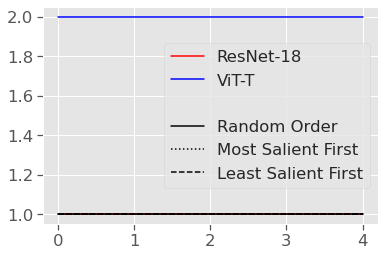

In [47]:
def get_handles(method_subset=None):
    fig, ax = plt.subplots(1, 1)
    dummy_x = np.arange(5)
    dummy_y = np.ones(5)
    for i, model_name in enumerate(['resnet18', 'deit_tiny_resnet_aug_missingness']):
        pretty_name = mapping_name_[model_name]
        sns.lineplot(x=dummy_x, y=dummy_y+i, color=COLORS[pretty_name], linestyle='-', label=pretty_name, ax=ax)
    ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
    
    if method_subset is not None:
        m_to_consider = [u for u in METHODS if u[0] in method_subset]
    else:
        m_to_consider = METHODS
    if len(m_to_consider) > 1:
        for m, method, style in METHODS:
            sns.lineplot(x=dummy_x, y=dummy_y, color='black', linestyle=style, label=method, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    plt.show()
    return handles, labels
handles, labels = get_handles()


In [48]:
model_entropies

{'deit_tiny_resnet_aug_missingness': {'random': [6.874068244064346,
   6.873206102180156,
   6.873810830411174,
   6.873924086385927,
   6.87459311217388,
   6.874695213302723,
   6.873957237600491,
   6.87375197116501,
   6.873415989737304,
   6.871899322812464,
   6.87312192206086,
   6.8728730207732145,
   6.872520005776385,
   6.8724127122104335,
   6.87167803320213,
   6.872040831540111,
   6.871408311991747,
   6.871607553021791,
   6.87183665357304,
   6.871300771133007,
   6.8712790920465965,
   6.869994686706709,
   6.87049705911635,
   6.871478043244369,
   6.869818622857777,
   6.869721825063124,
   6.867416302022419,
   6.866989681412759,
   6.8660158456788825,
   6.865791401174995,
   6.86581430968524,
   6.864791442862797,
   6.864565034737202,
   6.863227324928636,
   6.862884564630936,
   6.862428501217207,
   6.863200747721162,
   6.861973790367504,
   6.863219850985186,
   6.862185267969333,
   6.862077154938664,
   6.860616869879163,
   6.860853721436756,
   6.860294

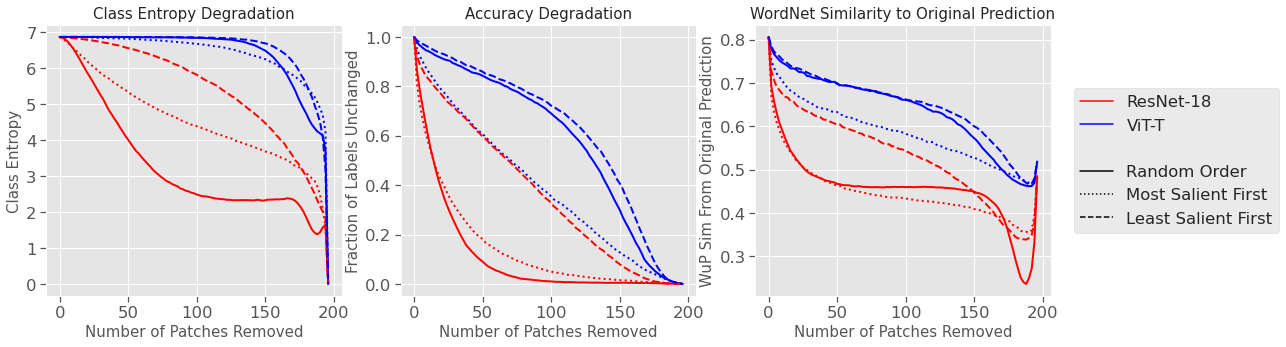

In [50]:
fig, ax = plt.subplots(1, 3,figsize=(18, 5))
patch_plots(ax[0], model_entropies, 
            "Number of Patches Removed",
            "Class Entropy", 
            "Class Entropy Degradation")
patch_plots(ax[1], model_accuracies, 
            "Number of Patches Removed", 
            "Fraction of Labels Unchanged",
            "Accuracy Degradation")
patch_plots(ax[2], wordnet_scores_inc,
            'Number of Patches Removed', 
            'WuP Sim From Original Prediction',
            'WordNet Similarity to Original Prediction')
# ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax[-1].legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.savefig(f"appendix_plots/color_patches/{title}", bbox_inches='tight')
plt.show()

## Color Plots

In [14]:
patch_size = 16
skip_factor = 2

num_patches = 224//patch_size
total_patches = num_patches*num_patches + 1
patch_axis = np.arange(0, total_patches , skip_factor)


In [15]:
# out_dir = os.path.join("plots", folder_name)
# os.makedirs(out_dir, exist_ok=True)
# os.makedirs(os.path.join(out_dir, 'barplots'), exist_ok=True)

In [16]:
ROOT

'/mnt/nfs/home/saachij/src/CausalDomainTransfer/patch_ablation/missingness_results'

In [32]:
root_dirs = {}
vit_folder_name = "patch_16_0_0_0"
root_dirs["deit_small_resnet_aug_missingness"] = os.path.join(ROOT, vit_folder_name, "deit_small_resnet_aug_missingness")

resnet_folder_name = "patch_16_-3_-3_-3"
title = "blur.pdf"

# resnet_folder_name = "patch_16_-1_-1_-1"
# title = "random_patch_color.pdf"

# resnet_folder_name = "patch_16_-2_-2_-2"
# title = "random_pixel_color.pdf"

# resnet_folder_name = "patch_16_0.485_0.456_0.406"
# title = "mean_color.pdf"

# resnet_folder_name = "patch_16_0_0_0"
# title = "black_condensed.pdf"

root_dirs["resnet50"] = os.path.join(ROOT, resnet_folder_name, "resnet50")


In [33]:
all_out_dicts = unwrap_envelopes(root_dirs)
model_counts, model_entropies, model_accuracies, model_soft_accuracies = unwrap_all_out_dicts(all_out_dicts, total_patches, skip_factor)
wordnet_scores, wordnet_scores_inc = unwrap_wordnet_scores(all_out_dicts)

In [34]:
METHODS

[('random', 'Random Order', '-'),
 ('Saliency', 'Most Salient First', ':'),
 ('Saliency_reverse', 'Least Salient First', '--')]

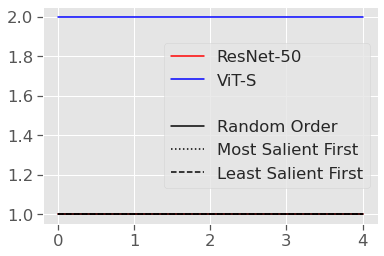

In [35]:
def get_handles(method_subset=None):
    fig, ax = plt.subplots(1, 1)
    dummy_x = np.arange(5)
    dummy_y = np.ones(5)
    for i, model_name in enumerate(['resnet50', 'deit_small_resnet_aug_missingness']):
        pretty_name = mapping_name_[model_name]
        sns.lineplot(x=dummy_x, y=dummy_y+i, color=COLORS[pretty_name], linestyle='-', label=pretty_name, ax=ax)
    ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
    
    if method_subset is not None:
        m_to_consider = [u for u in METHODS if u[0] in method_subset]
    else:
        m_to_consider = METHODS
    if len(m_to_consider) > 1:
        for m, method, style in METHODS:
            sns.lineplot(x=dummy_x, y=dummy_y, color='black', linestyle=style, label=method, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    plt.show()
    return handles, labels
handles, labels = get_handles()


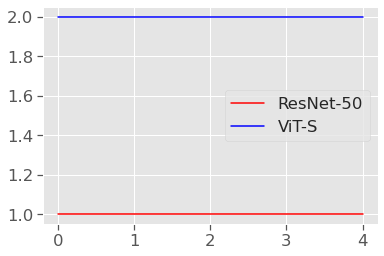

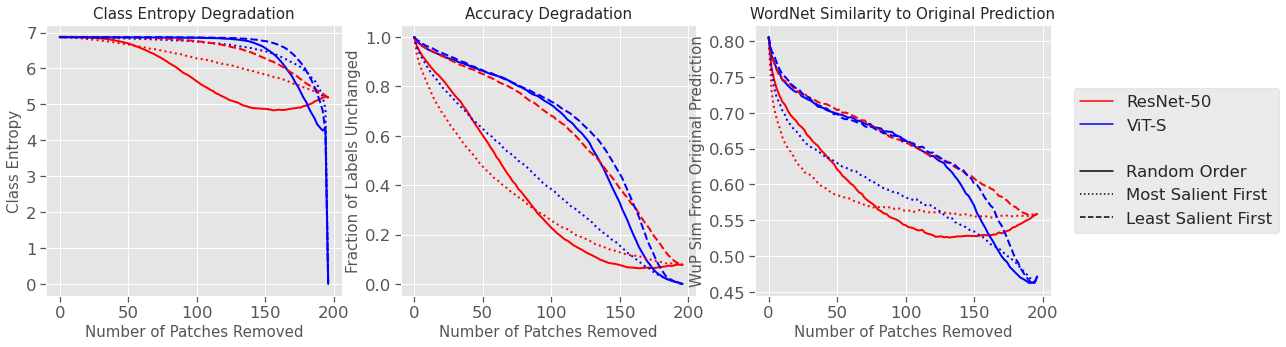

In [36]:
plot_handle, plot_label = get_handles(['random'])

fig, ax = plt.subplots(1, 3,figsize=(18, 5))
patch_plots(ax[0], model_entropies, 
            "Number of Patches Removed",
            "Class Entropy", 
            "Class Entropy Degradation")
patch_plots(ax[1], model_accuracies, 
            "Number of Patches Removed", 
            "Fraction of Labels Unchanged",
            "Accuracy Degradation")
patch_plots(ax[2], wordnet_scores_inc,
            'Number of Patches Removed', 
            'WuP Sim From Original Prediction',
            'WordNet Similarity to Original Prediction')
# ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax[-1].legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.savefig(f"appendix_plots/color_patches/{title}", bbox_inches='tight')
plt.show()

In [115]:
def make_bar_plot(model_counts, model_name, method, title, ax):
    font_size=18
    all_cts = model_counts[model_name][method]
    mid_index = patch_axis.tolist().index((total_patches - 1)//2)
    mid_cts = all_cts[mid_index]
    first_cts = all_cts[0]
    total_cts = sum([u[0] for u in mid_cts])
    first_cts_map = {u[1]: u[0]/total_cts for u in first_cts}
    mid_cts_map = {u[1]: u[0]/total_cts for u in mid_cts}
    normalized_cts = [(mid_cts_map[l],first_cts_map[l], l) for  _, l in mid_cts]

    key_name = 'Tokens Removed' if 'missingness' in model_name else 'Blacked Out'
    df = pd.DataFrame(normalized_cts[:30], columns=[f"50% {key_name}", f"0% {key_name}",'Label Name'])
    df = df.melt('Label Name')
    g = sns.barplot(data=df, x='Label Name', y='value', hue='variable', ax=ax)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, size=font_size, horizontalalignment='right')
    ax.set_ylabel('Fraction of Predictions', fontsize=font_size)
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 0.5)
    ax.axhline(1/1000.0, color='gray', label='Uniform', linewidth=2, linestyle='-')
    ax.set_title(title, fontsize=font_size)
    ax.legend()

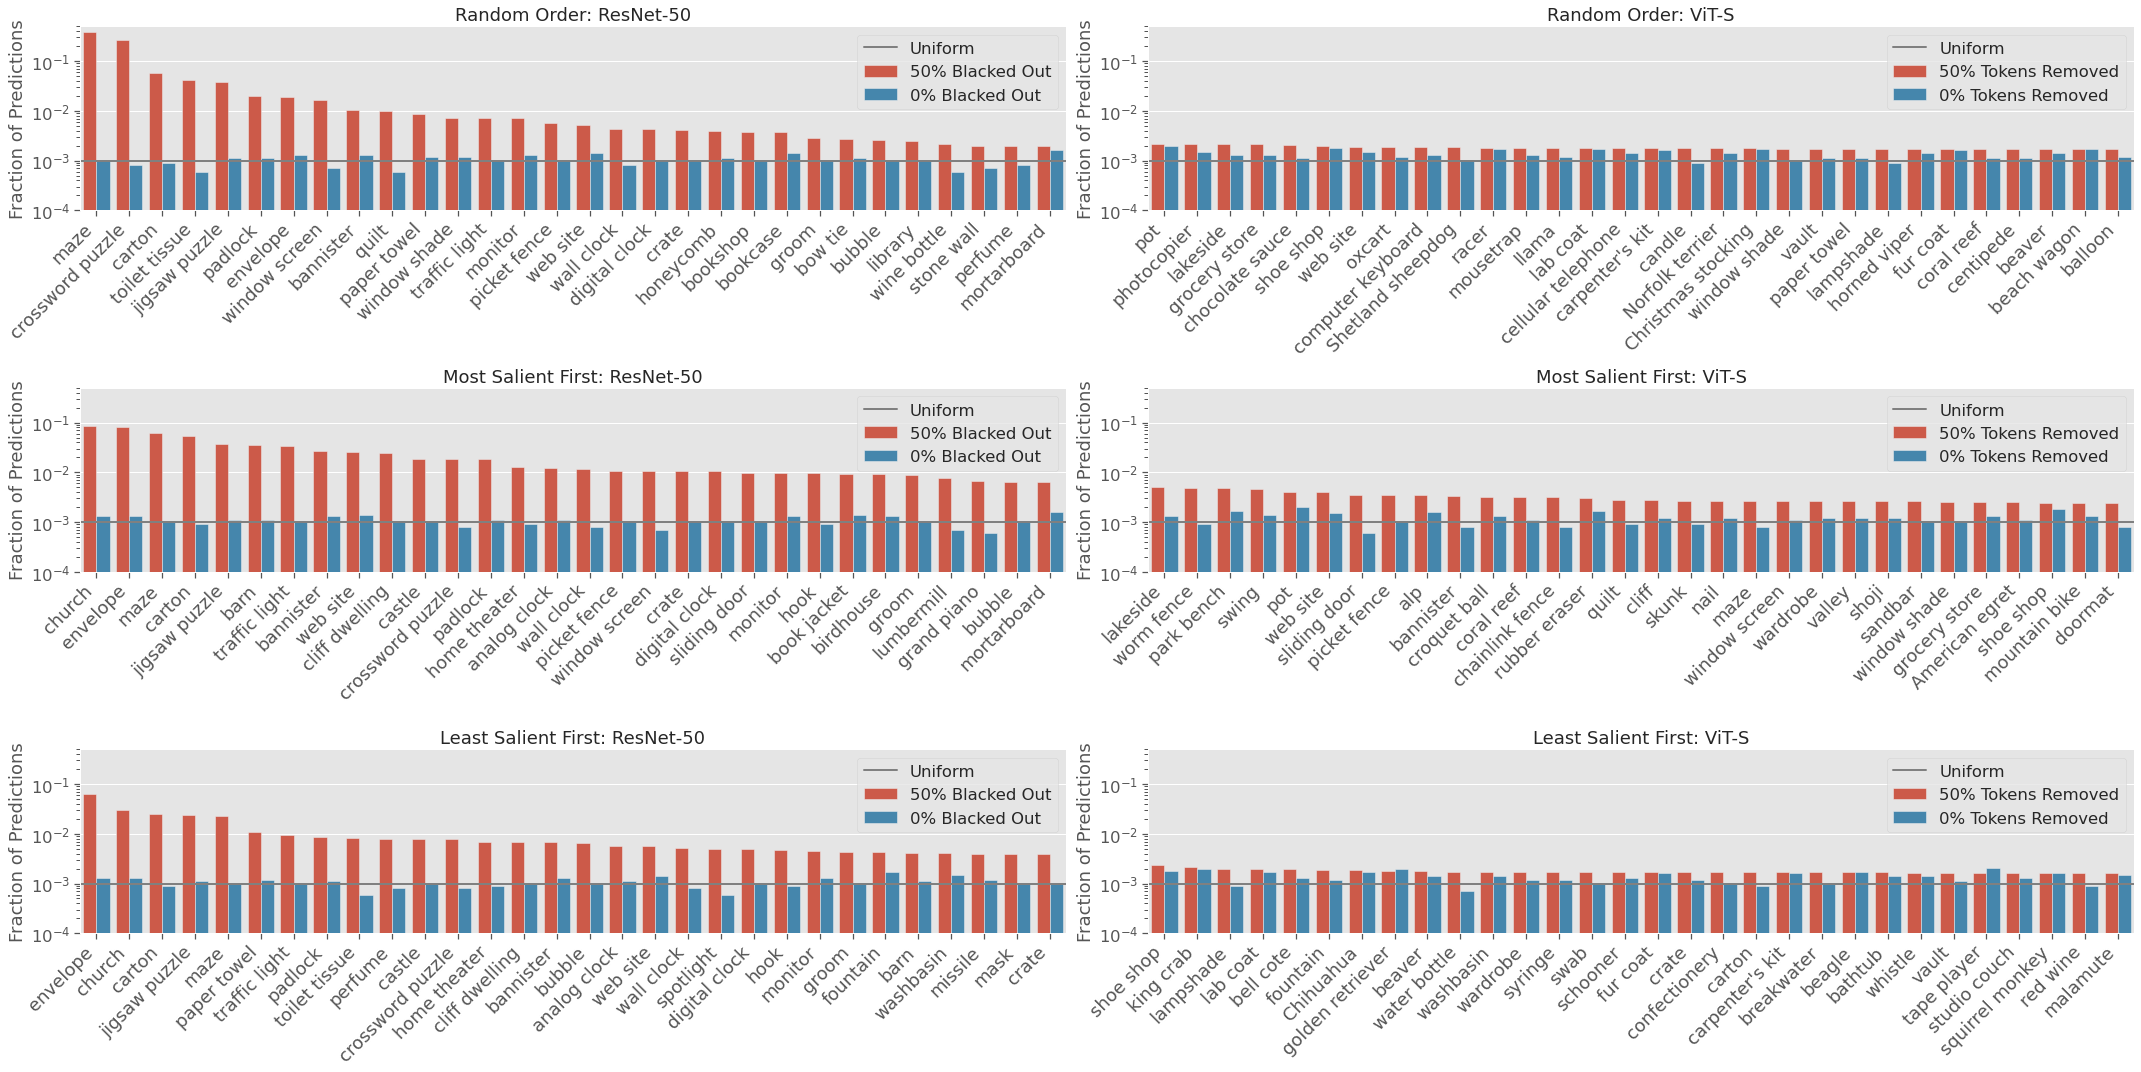

In [116]:
fig, ax = plt.subplots(len(METHODS), 2, figsize=(30, 5*len(METHODS)))

for j, (method, method_name, _) in enumerate(METHODS):
    for i, model in enumerate(['resnet50', 'deit_small_resnet_aug_missingness']):
        make_bar_plot(model_counts, 
                      model,
                      method,
                      f"{method_name}: {mapping_name_[model]}",
                      ax[j, i])
plt.tight_layout()
fig.savefig(f"appendix_plots/color_patches/barplot_{title}", bbox_inches='tight')
plt.show()

## Size Plots

In [14]:
patch_size = 8
skip_factor = 2
title = "8_patch_plot.pdf"

num_patches = 224//patch_size
total_patches = num_patches*num_patches + 1
patch_axis = np.arange(0, total_patches , skip_factor)


In [15]:
root_dirs = {}
folder_name = f"patch_{patch_size}_0_0_0"
root_dirs["deit_small_resnet_aug_missingness"] = os.path.join(ROOT, folder_name, "deit_small_resnet_aug")

# resnet_folder_name = "patch_16_-1_-1_-1"
# title = "random_patch_color.pdf"

# resnet_folder_name = "patch_16_-2_-2_-2"
# title = "random_pixel_color.pdf"

# resnet_folder_name = "patch_16_0.485_0.456_0.406"
# title = "mean_color.pdf"


root_dirs["resnet50"] = os.path.join(ROOT, folder_name, "resnet50")


In [16]:
all_out_dicts = unwrap_envelopes(root_dirs)
model_counts, model_entropies, model_accuracies, model_soft_accuracies = unwrap_all_out_dicts(all_out_dicts, total_patches, skip_factor)
wordnet_scores, wordnet_scores_inc = unwrap_wordnet_scores(all_out_dicts)

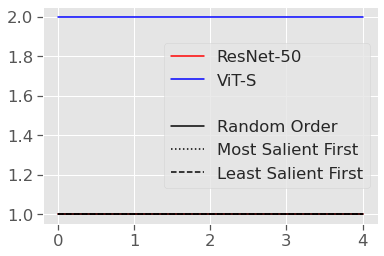

In [17]:
def get_handles(method_subset=None):
    fig, ax = plt.subplots(1, 1)
    dummy_x = np.arange(5)
    dummy_y = np.ones(5)
    for i, model_name in enumerate(['resnet50', 'deit_small_resnet_aug_missingness']):
        pretty_name = mapping_name_[model_name]
        sns.lineplot(x=dummy_x, y=dummy_y+i, color=COLORS[pretty_name], linestyle='-', label=pretty_name, ax=ax)
    ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
    
    if method_subset is not None:
        m_to_consider = [u for u in METHODS if u[0] in method_subset]
    else:
        m_to_consider = METHODS
    if len(m_to_consider) > 1:
        for m, method, style in METHODS:
            sns.lineplot(x=dummy_x, y=dummy_y, color='black', linestyle=style, label=method, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    plt.show()
    return handles, labels
handles, labels = get_handles()


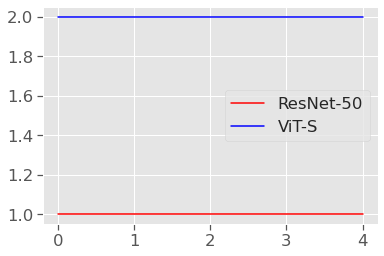

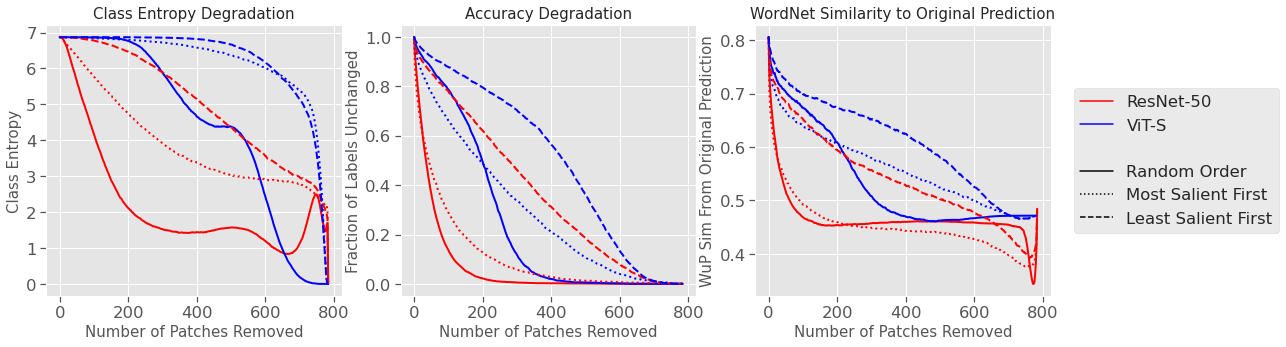

In [18]:
plot_handle, plot_label = get_handles(['random'])

fig, ax = plt.subplots(1, 3,figsize=(18, 5))
patch_plots(ax[0], model_entropies, 
            "Number of Patches Removed",
            "Class Entropy", 
            "Class Entropy Degradation")
patch_plots(ax[1], model_accuracies, 
            "Number of Patches Removed", 
            "Fraction of Labels Unchanged",
            "Accuracy Degradation")
patch_plots(ax[2], wordnet_scores_inc,
            'Number of Patches Removed', 
            'WuP Sim From Original Prediction',
            'WordNet Similarity to Original Prediction')
# ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax[-1].legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.savefig(f"appendix_plots/color_patches/{title}", bbox_inches='tight')
plt.show()

In [27]:
all_out_dicts

{'deit_small_resnet_aug_missingness': {'mask_accs': {'random': tensor([[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),
   'Saliency_reverse': tensor([[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [0, 0, 0,  ..., 1, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),
   'Saliency': tensor([[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 1, 1, 1],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 1],
           [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)},
  'mask_soft_labels': {'random': tensor([[8.3840e-01, 9.9748e-01, 9.9688e-01,  ..., 9.9980e-01, 6.5048e-01,
            5.3345e-01

## Superpixels

In [9]:
patch_axis = np.arange(0, 51 , 1)
total_patches = 51
skip_factor=1

In [10]:
root_dirs = {}
folder_name = f"slic_superpixel"
root_dirs["deit_small_resnet_aug_missingness"] = os.path.join(ROOT, folder_name, "deit_small_resnet_aug")

# resnet_folder_name = "patch_16_-1_-1_-1"
# title = "random_patch_color.pdf"

# resnet_folder_name = "patch_16_-2_-2_-2"
# title = "random_pixel_color.pdf"

# resnet_folder_name = "patch_16_0.485_0.456_0.406"
# title = "mean_color.pdf"

title = "slic_superpixel.pdf"

root_dirs["resnet50"] = os.path.join(ROOT, folder_name, "resnet50")


In [38]:
def unwrap(d):
    if isinstance(d, dict):
        return {k: unwrap(d[k]) for k in d.keys()}
    if isinstance(d, list):
        return [unwrap(k) for k in d]
    else:
        if d.shape[1] == len(example_mask):
            return d[:, example_mask]
        else:
            return d

In [50]:
import numpy as np
superpixels = np.load("/mnt/nfs/home/saachij/src/CausalDomainTransfer/patch_ablation/missingness_results/saliency_maps/slic_superpixel.npy")
max_vals = superpixels.reshape(10000, -1).max(axis=1)
example_mask = np.logical_and(max_vals < 150, max_vals >= 130)

all_out_dicts = unwrap(unwrap_envelopes(root_dirs))
model_counts, model_entropies, model_accuracies, model_soft_accuracies = unwrap_all_out_dicts(all_out_dicts, total_patches, skip_factor)
wordnet_scores, wordnet_scores_inc = unwrap_wordnet_scores(all_out_dicts)

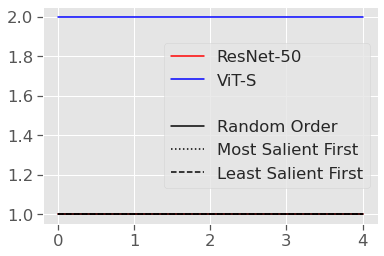

In [51]:
def get_handles(method_subset=None):
    fig, ax = plt.subplots(1, 1)
    dummy_x = np.arange(5)
    dummy_y = np.ones(5)
    for i, model_name in enumerate(['resnet50', 'deit_small_resnet_aug_missingness']):
        pretty_name = mapping_name_[model_name]
        sns.lineplot(x=dummy_x, y=dummy_y+i, color=COLORS[pretty_name], linestyle='-', label=pretty_name, ax=ax)
    ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')
    
    if method_subset is not None:
        m_to_consider = [u for u in METHODS if u[0] in method_subset]
    else:
        m_to_consider = METHODS
    if len(m_to_consider) > 1:
        for m, method, style in METHODS:
            sns.lineplot(x=dummy_x, y=dummy_y, color='black', linestyle=style, label=method, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    plt.show()
    return handles, labels
handles, labels = get_handles()


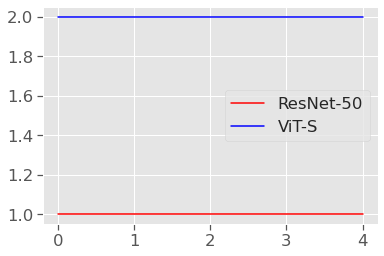

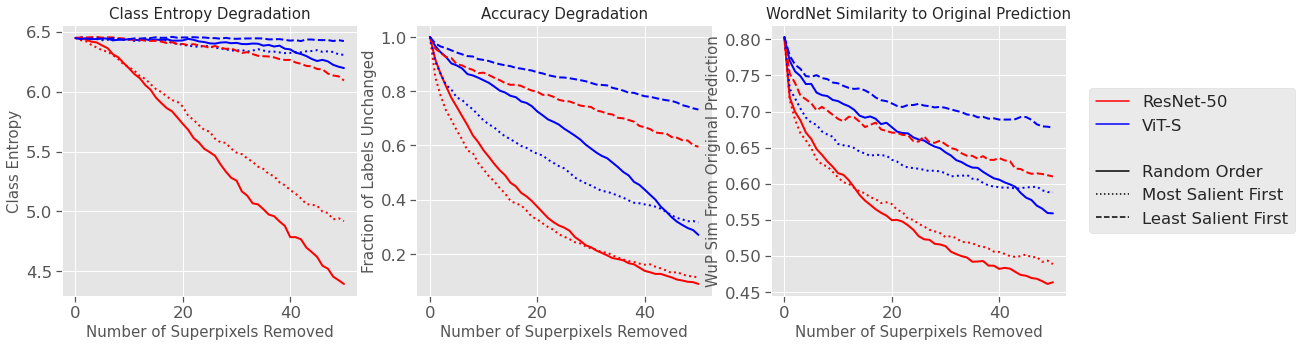

In [52]:
plot_handle, plot_label = get_handles(['random'])

fig, ax = plt.subplots(1, 3,figsize=(18, 5))
patch_plots(ax[0], model_entropies, 
            "Number of Superpixels Removed",
            "Class Entropy", 
            "Class Entropy Degradation")
patch_plots(ax[1], model_accuracies, 
            "Number of Superpixels Removed", 
            "Fraction of Labels Unchanged",
            "Accuracy Degradation")
patch_plots(ax[2], wordnet_scores_inc,
            'Number of Superpixels Removed', 
            'WuP Sim From Original Prediction',
            'WordNet Similarity to Original Prediction')
# ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax[-1].legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.savefig(f"appendix_plots/color_patches/{title}", bbox_inches='tight')
plt.show()

In [ ]:
len(model_entropies['resnet50']['random'])

In [25]:
patch_axis.shape

(50,)

# Entropy and Envelope Plots

In [69]:
# ENTROPY CALCULATIONS
def get_entropy(count_vec):
    tot = sum(count_vec)
    preds = count_vec/tot
    entropy = -sum(preds * np.log(preds))
    return entropy

def get_entropies_and_counts(out_dict):
    preds = out_dict['mask_preds']
    all_counts, all_entropies = {}, {}
    for method in preds.keys():
        entropies, counts = [], []
        for i in range(len(np.arange(0, total_patches, skip_factor))):
            labels_in_cls = {}
            predicted_labels = preds[method][i].numpy()
            for l in predicted_labels:
                if l not in labels_in_cls:
                    label_name = label_map[l].split(",")[0]
                    labels_in_cls[l] = [label_name, 1]
                else:
                    labels_in_cls[l][1] += 1
            out = sorted([(count, name) for name, count in labels_in_cls.values()])[::-1]
            counts.append(out)
            entropies.append(get_entropy(np.array([r[0] for r in out])))
        all_counts[method] = counts
        all_entropies[method] = entropies
    return all_entropies, all_counts

def get_envelope(out_dict):
    accs, soft_accs = out_dict['mask_accs'], out_dict['mask_soft_labels']
    df = pd.DataFrame()
    all_accuracies = {}
    for m in accs.keys():
        acc_mat = accs[m]
        mean_acc = torch.mean(acc_mat.float(), -1)
        all_accuracies[m] = mean_acc.numpy()
    all_soft_accuracies = {}
    for m in accs.keys():
        soft_mat = soft_accs[m]
        mean_score = torch.mean(soft_mat.float(), -1)
        all_soft_accuracies[m] = mean_score.numpy()
    return all_accuracies, all_soft_accuracies

In [71]:
import nltk
from nltk.corpus import wordnet as wn
# nltk.download('wordnet')
import json
with open("/mnt/nfs/home/datasets/imagenet_wordnet_info/imagenet_class_index.json", 'r') as f:
    imagenet_cls_idx = json.load(f)

In [72]:
# similarities = np.zeros((1000, 1000))
# for i in range(1000):
#     syn1 = imagenet_cls_idx[str(i)][0]
#     num1 = int(syn1.split('n')[1])
#     wn1 = wn.synset_from_pos_and_offset('n',num1)
#     if i % 10 == 0:
#         print(i)
#     for j in range(1000):
#         syn2 = imagenet_cls_idx[str(j)][0]
#         num2 = int(syn2.split('n')[1])
#         wn2 = wn.synset_from_pos_and_offset('n',num2)
#         similarities[i, j] = wn1.wup_similarity(wn2)
# np.save('similarities.npy', similarities)
similarities = np.load('similarities.npy')

In [73]:
def get_wordnet_scores(out_dict):
    preds = out_dict['mask_preds']
    all_sim_digression = {}
    all_sim_digression_inc = {}
    for m in preds.keys():
        preds_mat = preds[m].numpy()
        all_sims = []
        for b in range(preds_mat.shape[1]):
            vec = preds_mat[:, b]
            all_sims.append(similarities[vec[0]][vec])
        sim_digression = np.stack(all_sims, axis=1)
        all_sim_digression[m] = sim_digression.mean(-1)
        sim_digression_nan = np.copy(sim_digression)
        sim_digression_nan[sim_digression_nan == 1] = np.nan
        all_sim_digression_inc[m] = np.nanmean(sim_digression_nan, axis=-1)
    return all_sim_digression, all_sim_digression_inc

wordnet_scores, wordnet_scores_inc = {}, {}
for model_name, out_dict in all_out_dicts.items():
    wordnet_scores[model_name], wordnet_scores_inc[model_name] = get_wordnet_scores(out_dict)    

In [74]:
# plot entropy
def patch_plots(ax, result_dict, x_label, y_label, title, method_subset=None):
#     fig, ax = plt.subplots(1, 3,figsize=(18, 5))
    for i, (method, method_name, method_style) in enumerate(METHODS):
        if method_subset is not None and method not in method_subset:
            continue
        for model in MODEL_NAMES:
            sns.lineplot(x=patch_axis,
                         y=result_dict[model][method], 
                         ax=ax,
                         color=COLORS[mapping_name_[model]],
                         linestyle=method_style,
                         linewidth=2)
        if title is not None:
            ax.set_title(title, fontsize=15)
        ax.set_ylabel(y_label, fontsize=15)
        ax.set_xlabel(x_label, fontsize=15)
        ax.legend([],[], frameon=False)
#         if i !=2:
#             ax.legend([],[], frameon=False)
#         else:
#             ax[i].legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
#     fig.savefig(filename, bbox_inches='tight')
#     plt.show()


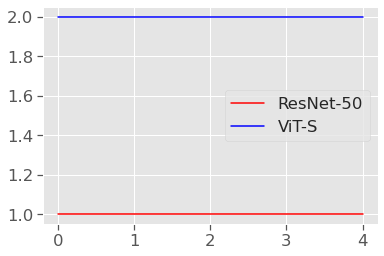

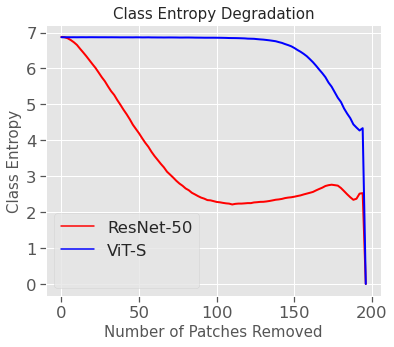

In [75]:
plot_handle, plot_label = get_handles(['random'])

fig, ax = plt.subplots(1, 1,figsize=(6, 5))
patch_plots(ax, model_entropies, 
            "Number of Patches Removed",
            "Class Entropy", 
            "Class Entropy Degradation", method_subset=['random'])
# patch_plots(ax[1], model_accuracies, 
#             "Number of Features Removed", 
#             "Fraction of Labels Changed",
#             "Accuracy Degradation", method_subset=['random'])
# patch_plots(wordnet_scores,
#             'Number of Features Removed', 
#             'WuP Distance From Original Prediction',
#              os.path.join(out_dir, "wordnet.pdf"))
# patch_plots(ax[2], wordnet_scores,
#             'Number of Features Removed', 
#             'WuP Sim From Original Prediction',
#             'WordNet Similarity to Original Prediction')
# ax.legend(plot_handle,plot_label, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
ax.legend(plot_handle,plot_label)
fig.savefig("class_entropy.pdf", bbox_inches='tight')
plt.show()

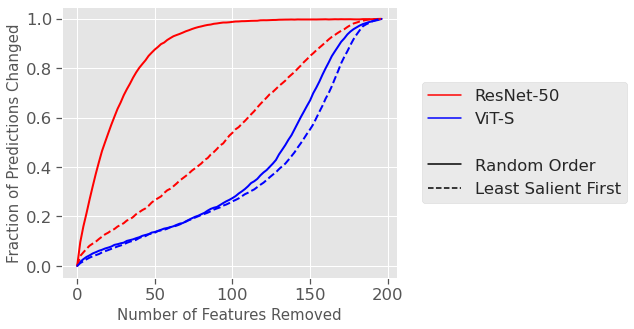

In [78]:
fig, ax = plt.subplots(1, 1,figsize=(6, 5))
patch_plots(ax, model_accuracies, 
            "Number of Features Removed", 
            "Fraction of Predictions Unchanged",
            None, method_subset=['random', 'Saliency_reverse'])
# patch_plots(wordnet_scores,
#             'Number of Features Removed', 
#             'WuP Distance From Original Prediction',
#              os.path.join(out_dir, "wordnet.pdf"))
# patch_plots(ax[2], wordnet_scores,
#             'Number of Features Removed', 
#             'WuP Sim From Original Prediction',
#             'WordNet Similarity to Original Prediction')
ax.legend(handles,labels, frameon=True, bbox_to_anchor=(1.05, 0.5), loc='center left')
fig.savefig("acc_degradation.pdf", bbox_inches='tight')
plt.show()

In [47]:
def make_bar_plot(model_counts, model_name, method, filename):
    font_size=18
    all_cts = model_counts[model_name][method]
    mid_index = patch_axis.tolist().index((total_patches - 1)//2)
    mid_cts = all_cts[mid_index]
    first_cts = all_cts[0]
    total_cts = sum([u[0] for u in mid_cts])
    first_cts_map = {u[1]: u[0]/total_cts for u in first_cts}
    mid_cts_map = {u[1]: u[0]/total_cts for u in mid_cts}
    normalized_cts = [(mid_cts_map[l],first_cts_map[l], l) for  _, l in mid_cts]

    key_name = 'Tokens Removed' if 'missingness' in model_name else 'Blacked Out'
    df = pd.DataFrame(normalized_cts[:30], columns=[f"50% {key_name}", f"0% {key_name}",'Label Name'])
    df = df.melt('Label Name')
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    g = sns.barplot(data=df, x='Label Name', y='value', hue='variable', ax=ax)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, size=font_size, horizontalalignment='right')
    ax.set_ylabel('Fraction of Predictions', fontsize=font_size)
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 0.5)
    ax.axhline(1/1000.0, color='gray', label='Uniform', linewidth=2, linestyle='-')
    ax.set_title(mapping_name_[model_name], fontsize=font_size)
    plt.legend()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

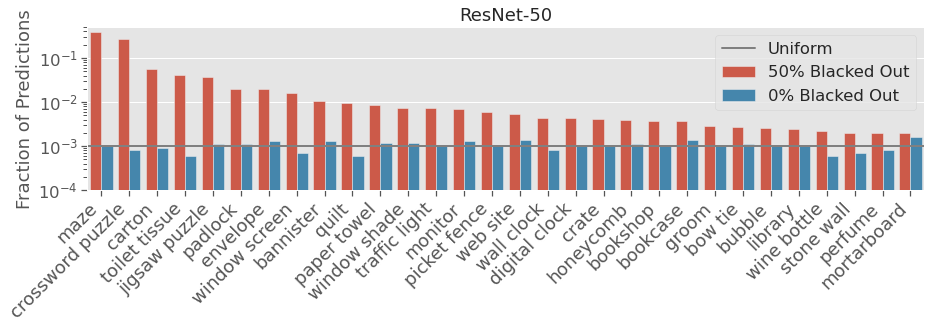

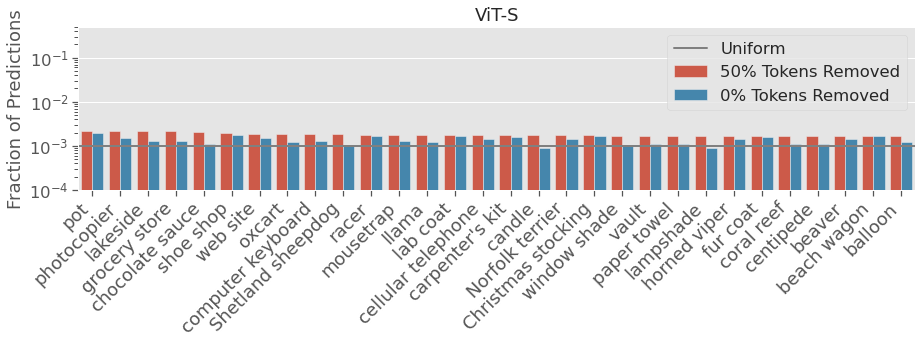

In [48]:
for method in ['random']:
    for model in MODEL_NAMES:
        make_bar_plot(model_counts, 
                      model,
                      method,
                      os.path.join(out_dir, 'barplots', f"{method}_{model}.pdf"))

## WordNet

99 99
99 99
99 99
99 99
99 99
99 99
99 99
99 99
99 99


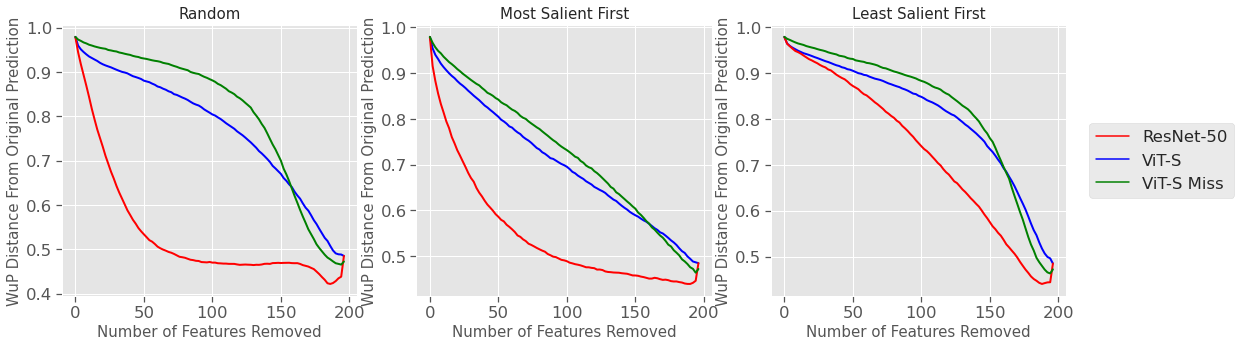

In [37]:
patch_plots(wordnet_scores,
            'Number of Features Removed', 
            'WuP Distance From Original Prediction',
             os.path.join(out_dir, "wordnet.pdf"))

99 99
99 99
99 99
99 99
99 99
99 99
99 99
99 99
99 99


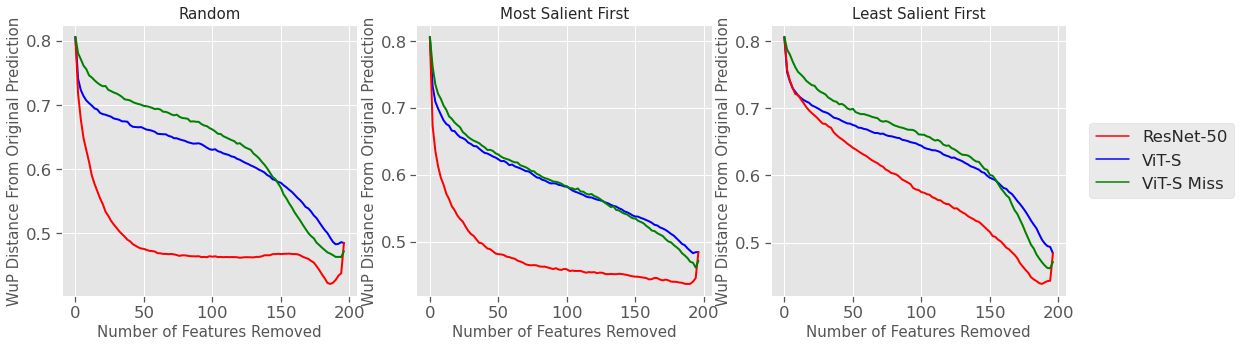

In [38]:
patch_plots(wordnet_scores_inc, 
            'Number of Features Removed', 
            'WuP Distance From Original Prediction',
            os.path.join(out_dir, "wordnet_if_incorrect.pdf"))